In [1]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import random
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\inesp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inesp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Info of the graph
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] =  graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] =  np.min(degrees) # minimum degree
    prop['max_degree'] =  np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] =  nx.density(graph) # density of the graph
    return prop

# Turning the training data into a graph

In [4]:
def get_training_graph(csv_file, column_names=['source', 'target', 'connected']):

    # Pandas dataframe
    df = pd.read_csv(csv_file, sep=' ', names=column_names)
    edges = df.loc[df['connected'] == 1]

    # Number of edges
    print(f'There are {len(edges)} edges and {len(df) - len(edges)} non edges')

    # networkx graph
    Graphtype = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges, create_using=Graphtype)
    
    return G

In [5]:
training_graph = get_training_graph('training_set.txt')

There are 335130 edges and 280382 non edges


In [6]:
compute_network_characteristics(graph=training_graph)

{'N': 27684,
 'M': 335130,
 'min_degree': 1,
 'max_degree': 2346,
 'mean_degree': 24.211096662332032,
 'median_degree': 14.0,
 'density': 0.0004372917794735403}

## For now let's focus on a smaller graph

In [7]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

In [9]:
random.seed(10)
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = [training_set[i] for i in to_keep]
print(f'We are only working on {len(training_set_reduced)} nodes of the dataset')

We are only working on 30776 nodes of the dataset


In [10]:
# Pandas dataframe
df = pd.DataFrame(training_set_reduced, columns=['source', 'target', 'connected'])
edges = df.loc[df['connected'] == '1']

# Number of edges
print(f'There are {len(edges)} edges and {len(df) - len(edges)} non edges')

# networkx graph !!!!!!! The graph is directed
Graphtype = nx.DiGraph()
G = nx.from_pandas_edgelist(edges, create_using=Graphtype)

# Take the largest weakly conected component
nodes = max(nx.weakly_connected_components(G), key=len) 
G0 = G.subgraph(nodes)

# Make that graph undirected
G0 = G0.to_undirected()
nx.is_connected(G0)

There are 16734 edges and 14042 non edges


True

In [20]:
compute_network_characteristics(G0)

{'N': 10030,
 'M': 14065,
 'min_degree': 1,
 'max_degree': 137,
 'mean_degree': 2.8045862412761715,
 'median_degree': 2.0,
 'density': 0.0002796476459543495}

## Generate Samples

In [21]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in tqdm(edges):
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    random.seed(10)
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels


In [22]:
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(G0, train_set_ratio=0.8)

## Get the feature Vector

In [24]:
print("degree centrality")
deg_centrality = nx.degree_centrality(G0)
print("done!")

katz_cent = nx.katz_centrality(G)
  
# print('betweeness_centrality')
# betweeness_centrality = nx.betweenness_centrality(G0)
# print('done!')

degree centrality
done!


In [49]:
def feature_extractor(graph, samples, deg_centrality):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    number_nodes_out = 0

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        if (source_node not in list(deg_centrality.keys())) or (target_node not in list(deg_centrality.keys())):
            feature_vector.append(np.array([0, 0, 0, 0, 0, 0, 0, 0]))
            number_nodes_out += 1

        else:

            source_degree_centrality = deg_centrality[source_node]
            target_degree_centrality = deg_centrality[target_node]
            source_katz_cent = katz_cent[source_node]
            target_katz_cent = katz_cent[target_node]
            
            # # Betweeness centrality measure 
            #diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

            # Preferential Attachement 
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

            # AdamicAdar
            aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

            # Jaccard
            jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
            # Ressource allocation index
            res_all = list(nx.resource_allocation_index(graph, [(source_node, target_node)]))[0][2]
            
            # Create edge feature vector with all metric computed above
            feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, source_katz_cent, target_katz_cent, pref_attach, aai, jacard_coeff, res_all]) ) 
    print(number_nodes_out)
        
    return np.array(feature_vector)

In [28]:
train_features = feature_extractor(G0, train_samples, deg_centrality)
test_features = feature_extractor(G0, test_samples, deg_centrality)


0



0


In [29]:
feat_train = pd.DataFrame(train_features, columns=['source_degree_centrality', 'target_degree_centrality', 'source_katz_cent', 'target_katz_cent', 'pref_attach', 'aai', 'jacard_coeff', 'res_all'])
feat_test = pd.DataFrame(test_features, columns=['source_degree_centrality', 'target_degree_centrality', 'source_katz_cent', 'target_katz_cent', 'pref_attach', 'aai', 'jacard_coeff', 'res_all'])

In [30]:
feat_train.head()

,source_degree_centrality,target_degree_centrality,source_katz_cent,target_katz_cent,pref_attach,aai,jacard_coeff,res_all
0,0.000100,0.000199,0.007114,0.007825,2.0,0.0,0.0,0.0
1,0.000199,0.000399,0.007825,0.010102,8.0,0.0,0.0,0.0
2,0.000199,0.002991,0.007114,0.035279,60.0,0.0,0.0,0.0
3,0.000997,0.000399,0.015121,0.012599,40.0,0.0,0.0,0.0
4,0.000997,0.000399,0.015121,0.007976,40.0,0.0,0.0,0.0


In [31]:
t_set_red = {}
for source, target, lab in training_set_reduced:
    t_set_red[(source, target)] = lab

In [32]:
def get_true_test_labels(test_samples):
    real_test_labels = []

    for edge in test_samples:
        if (edge[0], edge[1]) in list(t_set_red.keys()):
            real_test_labels.append(int(t_set_red[(edge[0], edge[1])]))
        else:
            real_test_labels.append(0)
    return real_test_labels

In [33]:
real_test_labels = get_true_test_labels(test_samples)

In [34]:
def prediction(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    labels_pred = clf.predict(test_features)

    print(f'Accuracy: {accuracy_score(test_labels, labels_pred)}')
    print(f'F1 score: {f1_score(test_labels, labels_pred)}')

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

Accuracy: 0.6347795163584637
F1 score: 0.45138888888888895


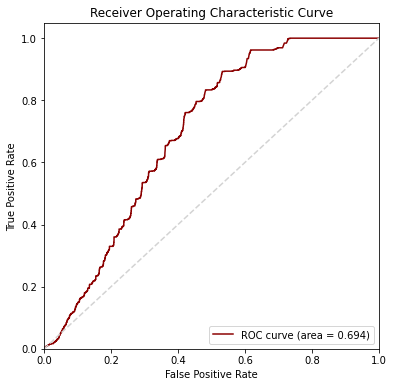

0.6938333906182096

In [35]:
prediction(G0, train_features, test_features, train_labels, real_test_labels)

# Adding additional information

In [36]:
column_names = ['id', 'year', 'title', 'authors', 'journal', 'abstract']
info = pd.read_csv('node_information.csv', sep=',', names=column_names)
info.head()

,id,year,title,authors,journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


In [37]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

In [38]:
vect = TfidfVectorizer(stop_words="english")
abstract_vectorized = vect.fit_transform(info['abstract'])

In [39]:
def preprocessing_info(sample, abstract_vectorized):
    # number of overlapping words in title
    overlap_title = []

    # temporal distance between the papers
    temp_diff = []

    # number of common authors
    comm_auth = []

    # Cosine sim between abstracts
    cosine_sim = []

    dense_matrix = abstract_vectorized.todense()

    counter = 0
    for i in range(len(sample)):
        source = sample[i][0]
        target = sample[i][1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]
        
        # convert to lowercase and tokenize
        source_title = source_info[2].lower().split(" ")
        # remove stopwords
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]
        
        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]
        
        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")
        
        overlap_title.append(len(set(source_title).intersection(set(target_title))))
        temp_diff.append(int(source_info[1]) - int(target_info[1]))
        comm_auth.append(len(set(source_auth).intersection(set(target_auth))))

        v1 = dense_matrix[index_source,:]
        v2 = dense_matrix[index_target,:]

        sim = cosine_similarity(v1, v2)
        cosine_sim.append(sim[0][0])
    
        counter += 1
        if counter % 1000 == True:
            print(counter, "training examples processsed")

    return overlap_title, temp_diff, comm_auth, cosine_sim

In [40]:
overlap_title_train, temp_diff_train, comm_auth_train, cosine_sim_train = preprocessing_info(train_samples, abstract_vectorized)

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed


In [41]:
overlap_title_test, temp_diff_test, comm_auth_test, cosine_sim_test = preprocessing_info(test_samples, abstract_vectorized)

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed


In [42]:
def get_training_features(overlap_title, temp_diff, comm_auth, sim):
    training_features = np.array([overlap_title, temp_diff, comm_auth, sim]).T
    training_features = preprocessing.scale(training_features)
    df = pd.DataFrame(training_features, columns=['overl_title', 'temp_diff', 'comm_author', 'sim'])
    return training_features, df

In [43]:
training_add_feat = get_training_features(overlap_title_train, temp_diff_train, comm_auth_train, cosine_sim_train)[1]
testing_add_feat = get_training_features(overlap_title_test, temp_diff_test, comm_auth_test, cosine_sim_test)[1]

In [44]:
all_train_feat = pd.concat([feat_train, training_add_feat], axis=1)
all_test_feat = pd.concat([feat_test, testing_add_feat], axis=1)

In [45]:
all_train_feat.head()

,source_degree_centrality,target_degree_centrality,source_katz_cent,target_katz_cent,pref_attach,aai,jacard_coeff,res_all,overl_title,temp_diff,comm_author,sim
0,0.000100,0.000199,0.007114,0.007825,2.0,0.0,0.0,0.0,-0.564055,0.331331,-0.20986,-0.231864
1,0.000199,0.000399,0.007825,0.010102,8.0,0.0,0.0,0.0,-0.564055,0.622402,-0.20986,0.152005
2,0.000199,0.002991,0.007114,0.035279,60.0,0.0,0.0,0.0,-0.564055,0.913473,-0.20986,-0.123473
3,0.000997,0.000399,0.015121,0.012599,40.0,0.0,0.0,0.0,0.582808,0.040261,-0.20986,0.350380
4,0.000997,0.000399,0.015121,0.007976,40.0,0.0,0.0,0.0,0.582808,-1.124023,-0.20986,-0.889942


C:\Users\inesp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy: 0.6548719772403983
F1 score: 0.5141426783479349


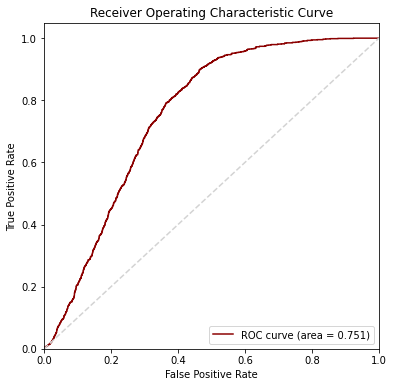

0.7514685800481775

In [46]:
prediction(G0, all_train_feat.to_numpy(), all_test_feat.to_numpy(), train_labels, real_test_labels)

# Getting the features of the test set

In [47]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

In [48]:
overlap_title_test = []
temp_diff_test = []
comm_auth_test = []
cosine_sim_test = []
dense_matrix = abstract_vectorized.todense()
   
counter = 0
for i in range(len(testing_set)):

    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_title = source_info[2].lower().split(" ")
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    temp_diff_test.append(int(source_info[1]) - int(target_info[1]))
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))

    v1 = dense_matrix[index_source,:]
    v2 = dense_matrix[index_target,:]

    sim = cosine_similarity(v1, v2)
    cosine_sim_test.append(sim[0][0])
   
    counter += 1
    if counter % 1000 == True:
        print(counter, "testing examples processsed")

1 testing examples processsed
1001 testing examples processsed
2001 testing examples processsed
3001 testing examples processsed
4001 testing examples processsed
5001 testing examples processsed
6001 testing examples processsed
7001 testing examples processsed
8001 testing examples processsed
9001 testing examples processsed
10001 testing examples processsed
11001 testing examples processsed
12001 testing examples processsed
13001 testing examples processsed
14001 testing examples processsed
15001 testing examples processsed
16001 testing examples processsed
17001 testing examples processsed
18001 testing examples processsed
19001 testing examples processsed
20001 testing examples processsed
21001 testing examples processsed
22001 testing examples processsed
23001 testing examples processsed
24001 testing examples processsed
25001 testing examples processsed
26001 testing examples processsed
27001 testing examples processsed
28001 testing examples processsed
29001 testing examples proc

In [50]:
testing_features = np.array([overlap_title_test,temp_diff_test,comm_auth_test, cosine_sim_test]).T

testing_features = preprocessing.scale(testing_features)

In [51]:
test_feat = pd.DataFrame(testing_features, columns=['overl_title', 'temp_diff', 'comm_author', 'sim'])

In [53]:
test_graph_feat = feature_extractor(G0, testing_set, deg_centrality)


21001


In [54]:
test_graph_feat = pd.DataFrame(test_graph_feat, columns=['source_degree_centrality', 'target_degree_centrality', 'source_katz_cent', 'target_katz_cent', 'pref_attach', 'aai', 'jacard_coeff', 'res_all'])

In [55]:
total_test_feat = pd.concat([test_graph_feat, test_feat], axis=1)

In [56]:
total_test_feat.head()

,source_degree_centrality,target_degree_centrality,source_katz_cent,target_katz_cent,pref_attach,aai,jacard_coeff,res_all,overl_title,temp_diff,comm_author,sim
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.566312,-0.317649,-0.233924,0.007732
1,0.001994,0.000199,0.013730,0.009519,40.0,0.0,0.0,0.0,1.635671,-0.036092,-0.233924,1.109139
2,0.001296,0.004886,0.016399,0.051252,637.0,0.0,0.0,0.0,0.534679,0.245466,-0.233924,0.702924
3,0.000199,0.000199,0.007114,0.007114,4.0,0.0,0.0,0.0,0.534679,-0.317649,-0.233924,0.486097
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.566312,1.090138,-0.233924,2.608261


In [59]:
# initialize basic SVM
classifier = svm.LinearSVC(max_iter=50000)

# train
classifier.fit(all_train_feat.to_numpy(), train_labels)

C:\Users\inesp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=50000)

In [60]:
predictions_SVM = list(classifier.predict(total_test_feat.to_numpy()))

predictions_SVM = zip(range(len(testing_set)), predictions_SVM)

In [61]:
with open("improved_predictions_full_5%_with_katz.csv","w", newline='') as pred1:
    csv_out = csv.writer(pred1)
    for row in predictions_SVM:
        csv_out.writerow(row)